# Setup
### Data Loading

In [1]:
# VCF Locations   Folder     File
condition1VCF  = "vcf/%s" % "synthetic.challenge.set1.bloocoo.default.nobqsr.raw.snps.indels.vcf"
condition2VCF  = "vcf/%s" % "synthetic.challenge.set1.bloocoo.default.bqsr.raw.snps.indels.vcf"
truthVCF       = "vcf/truth-set/%s" % "synthetic.challenge.set1.tumor.all.truth.vcf"

### Imports & Methods

In [2]:
# Show Plots Inline
%matplotlib inline

from collections import OrderedDict
from operator import itemgetter
from statistics import mean, median, mode, stdev, variance
from sklearn import metrics
import sys
import operator

# Import General Libs
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as Plot
import numpy as Np
import vcf as VCF

Plot.ion()

# Set matplotlib style
matplotlib.style.use('ggplot')

#
# Data Structuring
#

# Variant Hashing Function
def hashVariants (records, props, algorithm = "md5"):
    """
    
    Hash VCF Records and Check for Collisions.
    Accepts Reader object (records) and an algorithm string (algorithm).
    
    @Params:
        PARAMETER    USAGE      DEFAULT   DESCRIPTION
        records    - Required -         - Iterable records object
        props      - Required -         - Properties of record in records iterable
        algorithm  - Optional - "md5"   - String of hashing algorithm 
    @Returns
        hashMap    - OrderdDict
        collisions - Boolean
        
    """
    import hashlib
    from collections import OrderedDict
    hashMap, count, collisions = OrderedDict(), 0, False
    for record in records:
        variantStr = "".join([str(getattr(record, prop)) for prop in props])
        variantMD5 = getattr(hashlib, algorithm)(variantStr.encode()).hexdigest()
        hashMap[variantMD5] = record
        count += 1
    if len(hashMap.keys()) != count:
        collisions = True
        print("Warning: Collision occurred. Try using a difference hashing function.")
        print("Available algorithms: %s\n" % ", ".join(hashlib.algorithms_available))
    return hashMap, collisions

def generateAnalysis (conditionHashMap, truthHashMap, metricKey = "TLOD", operation = "<", threshold = 100):
    # Map Operators
    operators = {
        '>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
        '=': operator.eq
    }
    # Setup Analysis by Threshold
    analysis = {
        "tp"          : set(),
        "fp"          : set(),
        "tn"          : set(),
        "fn"          : set(),
        "sensitivity" : 0.0,
        "specificity" : 0.0,
        "precision"   : 0.0,
        "recall"      : 0.0,
        "tpr"         : 0.0,
        "tnr"         : 0.0,
        "fpr"         : 0.0,
        "fnr"         : 0.0,
        "accuracy"    : 0.0,
        "f1score"     : 0.0,
        "fdr"         : 0.0,
        "for"         : 0.0,
        "ppv"         : 0.0,
        "npv"         : 0.0,
        "diagnosticOR": 0.0,
        "n"           : 0
    }
    # Sort Variants into TP/TN/FP/FN Sets
    for hashKey, record in conditionHashMap.items():
        if operators[operation](float(record.INFO[metricKey]), threshold):
            if hashKey in truthHashMap:
                analysis["fn"].add(hashKey)
            else:
                analysis["tn"].add(hashKey)
        else:
            if hashKey in truthHashMap:
                analysis["tp"].add(hashKey)
            else:
                analysis["fp"].add(hashKey)

    # TP/TN/FP/FN Values - Add 0.000000000001 to Each to Prevent Zero-Division
    # While the Addition Theoretically Introduces a Bias, Practically Statistics are Unchanged (Validated)
    tp = len(analysis["tp"]) + 0.000000000001
    tn = len(analysis["tn"]) + 0.000000000001
    fp = len(analysis["fp"]) + 0.000000000001
    fn = len(analysis["fn"]) + 0.000000000001

    # Statistics (Some Computations Replicated for Naming)
    analysis["sensitivity"]   = tp / (tp + fn)
    analysis["specificity"]   = tn / (fp + tn)
    analysis["precision"]     = tp / (tp + fp)
    analysis["recall"]        = tp / (tp + fn)
    analysis["tpr"]           = tp / (tp + fn)
    analysis["tnr"]           = tn / (fp + tn)
    analysis["fpr"]           = fp / (fp + tn)
    analysis["fnr"]           = fn / (fn + tp)
    analysis["accuracy"]      = (tp + tn) / (tp + tn + fp + fn)
    analysis["f1score"]       = (2 * tp) / ((2 * tp) + (fp + fn))
    analysis["fdr"]           = fp / (fp + tp)
    analysis["for"]           = fn / (fn + tn)
    analysis["ppv"]           = tp / (fp + tp)
    analysis["npv"]           = tn / (fn + tn)
    analysis["diagnosticOR"]  = (tp / fp) / (fn / tn)
    analysis["n"]             = tp + fp + tn + fn
    return analysis

# Compute Lots of Statistics n' Stuff
def generateAnalyses (conditionHashMap, truthHashMap, metricKey = "TLOD", thresholds = 100, skip = 1):
    # Setup Data Structures
    analyses   = OrderedDict()
    # Use Thresholds to Classify Positive or Negative 
    for threshold in range(0, thresholds, skip):
        analyses[threshold] = generateAnalysis(conditionHashMap, truthHashMap, metricKey = metricKey, threshold = threshold)
    return analyses

def subsetHashMapByKeys (hashMap, keys, isfound = True):
    subset = {}
    for md5, record in hashMap.items():
        if isfound:
            if md5 in keys:
                subset[md5] = record
        else:
            if md5 not in keys:
                subset[md5] = record
    return subset

# Get Info Data From Records in Records HashMap
def subsetHashMapByInfoThreshold (hashMap, threshold, operation = ">", key = "TLOD"):
    subset, excluded = {}, {}
    operators = {
        '>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
        '=': operator.eq
    }
    for md5, record in hashMap.items():
        if key in record.INFO.keys() and operators[operation](record.INFO[key], threshold):
            subset[md5] = record
        else:
            excluded[md5] = record
    return subset, excluded

# Get Format Data From Records in Records HashMap
def subsetHashMapByFormatThreshold (hashMap, threshold, operation = ">", key = "AF", sampleIdx = 0):
    subset, excluded = {}, {}
    operators = {
        '>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
        '=': operator.eq
    }
    for md5, record in hashMap.items():
        sample = record.samples[sampleIdx]
        try:
            if type(sample[key]) is list and sum(operators[operation](sample[key], threshold)):
                subset[md5] = record
            elif operators[operation](sample[key], threshold):
                subset[md5] = record
            else: 
                excluded[md5] = record
        except:
            excluded[md5] = record
    return subset, excluded

# Get Info Data From Records in Records HashMap
def subsetHashMapByInfoRange (hashMap, rangeTup, key = "TLOD"):
    subset, excluded = {}, {}
    for md5, record in hashMap.items():
        if key in record.INFO.keys() and record.INFO[key] > rangeTup[0] and record.INFO[key] <= rangeTup[1]:
            subset[md5] = record
        else:
            excluded[md5] = record
    return subset, excluded

# Get Format Data From Records in Records HashMap
def subsetHashMapByFormatRange (hashMap, rangeTup, key = "AF", sampleIdx = 0):
    subset, excluded = {}, {}
    for md5, record in hashMap.items():
        sample = record.samples[sampleIdx]
        if sample[key]:
            if type(sample[key]) is list:
                add = sum(sample[key])
                if rangeTup[0] == 0:
                    subset[md5] = record
                elif add > rangeTup[0] and add <= rangeTup[1]:
                    subset[md5] = record
            else:
                if sample[key] > rangeTup[0] and sample[key] <= rangeTup[1]:
                    subset[md5] = record
        else:
            excluded[md5] = record
    return subset, excluded

# Generate Analysis by Threshold - A Macro Really
def generateMultipleAnalyses (condition, truth, key, thresholds, byType = "info"):
    analyses = []
    i = 0
    printProgress(i, len(thresholds), prefix = "Generating Analyses", suffix = "Computed", barLength = 50)
    for threshold in thresholds:
        if byType.lower() == "info":
            subset = subsetHashMapByInfo(condition, threshold, key = key)
        if byType.lower() == "format":
            subset = subsetHashMapByFormat(condition, threshold, key = key)
        if subset:
            analyses.append(generateAnalyses(subset, truth))
            i += 1
            printProgress(i, len(thresholds), prefix = "Generating Analyses", suffix = "Computed", barLength = 50)
        else:
            print("Error Subsetting: Ensure byType is specified as either 'info' or 'format' and that the key exists.")
    return analyses

#
# VCF Parsing
#

# Get Info Data From Records in Records HashMap
def getInfoData (hashMap, key = "TLOD"):
    data, excluded = [], {}
    for md5, record in hashMap.items():
        try:
            data.append(record.INFO[key])
        except:
            excluded[md5] = record
    return data, excluded

# Get Format Data From Records in Records HashMap
def getFormatData (hashMap, key = "AF", sampleIdx = 0):
    data, excluded = [], {}
    types = set()
    for md5, record in hashMap.items():
        try:
            sample = record.samples[sampleIdx]
            data.append(sample[key])
        except:
            excluded[md5] = record
    return data, excluded

# Retrieve Passing Variants (i.e. Those Which Have No Failing Filters)
def passingVariants (hashMap):
    passing = {}
    for md5, record in hashMap.items():
        if len(record.FILTER) == 0:
            passing[md5] = record
    return passing

#
# Statistics Computation
#

# Compute Quartiles of a Vector
def quartiles(vector):
    from statistics import median
    sort = sorted(vector)
    mid = len(sort) // 2
    if (len(sort) % 2 == 0):
        lowerQ = median(sort[:mid])
        upperQ = median(sort[mid:])
    else:
        lowerQ = median(sort[:mid])
        upperQ = median(sort[mid+1:])
    return lowerQ, upperQ    

# Generate Basic Statistics Summary
def stats(vector, title = "Title"):
    lowerQ, upperQ = quartiles(vector)
    print("%s\n" % title)
    print("Measures of Central Tendency")
    print("\tMean          %s"  % mean(vector))
    print("\tMedian        %s"  % median(vector))
    print("\tMode          %s"  % mode(vector))
    print("Measures of Spread")
    print("\tstdev         %s"  % stdev(vector))
    print("\tvariance      %s"  % variance(vector))
    print("Distribution")
    print("\tMin           %s"  % min(vector))
    print("\tLower Quatile %s"  % lowerQ)
    print("\tMedian        %s"  % median(vector))
    print("\tUpper Quatile %s"  % upperQ)
    print("\tMax           %s\n"% max(vector))
    
def printStatistics (analysis):
    for threshold, records in analysis.items():
        brk()
        print("Tumor LOD Threshold: %d\n" % threshold)
        print("\tTrue Positive:     %d" % len(records["tp"]))
        print("\tTrue Negative:     %d" % len(records["tn"]))
        print("\tFalse Positive:    %d" % len(records["fp"]))
        print("\tFalse Negative:    %d\n" % len(records["fn"]))
        print("\tTPR:               %0.2f%%" % (records["tpr"] * 100))
        print("\tTNR:               %0.2f%%" % (records["tnr"] * 100))
        print("\tFPR:               %0.2f%%" % (records["fpr"] * 100))
        print("\tFNR:               %0.2f%%\n" % (records["fnr"] * 100))
        print("\tSensitivity:       %0.2f%%" % (records["sensitivity"] * 100))
        print("\tSpecificity:       %0.2f%%\n" % (records["specificity"] * 100))
        print("\tPrecision:         %0.2f%%" % (records["precision"] * 100))
        print("\tRecall:            %0.2f%%\n" % (records["recall"] * 100))
        print("\tAccuracy:          %0.2f%%" % (records["accuracy"] * 100))
        print("\tF1-Score:          %0.2f%%" % (records["f1score"] * 100))
        print("\tFDR:               %0.2f%%\n" % (records["fdr"] * 100))
        brk()

# Print Best by Some Metric
def printBest (analysis, metric = "accuracy"):
    threshold, best = max(enumerate([records[metric] for threshold, records in analysis.items()]), key=itemgetter(1))
    records = analysis[threshold]
    print("Best Threshold by '%s'\n" % metric)
    print("Tumor LOD Threshold: %d\n" % threshold)
    print("\tTrue Positive:     %d" % len(records["tp"]))
    print("\tTrue Negative:     %d" % len(records["tn"]))
    print("\tFalse Positive:    %d" % len(records["fp"]))
    print("\tFalse Negative:    %d\n" % len(records["fn"]))
    print("\tTPR:               %0.2f%%" % (records["tpr"] * 100))
    print("\tTNR:               %0.2f%%" % (records["tnr"] * 100))
    print("\tFPR:               %0.2f%%" % (records["fpr"] * 100))
    print("\tFNR:               %0.2f%%\n" % (records["fnr"] * 100))
    print("\tSensitivity:       %0.2f%%" % (records["sensitivity"] * 100))
    print("\tSpecificity:       %0.2f%%\n" % (records["specificity"] * 100))
    print("\tPrecision:         %0.2f%%" % (records["precision"] * 100))
    print("\tRecall:            %0.2f%%\n" % (records["recall"] * 100))
    print("\tAccuracy:          %0.2f%%" % (records["accuracy"] * 100))
    print("\tF1-Score:          %0.2f%%\n" % (records["f1score"] * 100))
    print("\tFDR:               %0.2f%%" % (records["fdr"] * 100))
    print("\tFOR:               %0.2f%%\n" % (records["for"] * 100))
    print("\tNPV:               %0.2f%%" % (records["npv"] * 100))
    print("\tPPV:               %0.2f%%\n" % (records["ppv"] * 100))
    print("\tDiagnostic OR:     %0.2f\n" % (records["diagnosticOR"] * 100))
    
#
# Repeated Computations
#

def computeQuals (hashMap):
    # Compute Quality Score Approximations
    QS = getFormatData(hashMap, "QSS")[0]
    AD = getFormatData(hashMap, "AD")[0]
    # Compute Mean Quality Scores for Reference & Alternate Alleles
    refQS = []
    altQS = []
    for qsPair, adPair in zip(QS, AD):
        if adPair[0] == 0 or adPair[1] == 0:
            pass
        else:
            refQS.append((qsPair[0] / adPair[0]))
            altQS.append((qsPair[1] / adPair[1]))
    return refQS, altQS

# Split Vector by Index of Value Ranges - Default by Value
def generateSplits (vector, n = 10, median = False):
    if median:
        # Split Vectors n Times by Their Median (Attempt to Evenly Distribute Vector by Rounding, Similar to a Split by Index)
        splits    = [vector[round(i * (len(vector) / n)): round((i + 1) * (len(vector) / n))] for i in range(n)]
        vecRanges = [(min(split), max(split)) for split in splits]
    else:
        # Sum Vector and Distribute Evenly by Value
        vecMin, vecMax = min(vector), max(vector)
        vecRanges = [(vecMin + (x * ((vecMax - vecMin) / n)), vecMin + ((x + 1) * ((vecMax - vecMin) / n))) for x in range(n)]
        splits    = [[x for x in vector if (x >= vecRange[0] and x < vecRange[1])] for vecRange in vecRanges]
    return splits, vecRanges

def getRanges (splits):
    ranges = []
    for split in splits:
        ranges.append([min(split), max(split)])
    return ranges    

#
# Interface Management
#

# Print iterations progress
def printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        barLength   - Optional  : character length of bar (Int)
    """
    formatStr = "{0:." + str(decimals) + "f}"
    percent = formatStr.format(100 * (iteration / float(total)))
    filledLength = int(round(barLength * iteration / float(total)))
    bar = '█' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percent, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()
    
# Print a Break
def brk(char = "-", n = 50):
    print("\n" + ("-" * n) + "\n")    

#
# Plotting
#

# Generate a Simple Inline Plot
def simpleInlinePlot (x, y, title = "", xlabel = "", ylabel = "", color = "green", plotType = "plot", size = (12, 12), dpi = 1200, domain = [], range = [], opacity = 0.1, bins = 1000):
    # Setup
    figure = Plot.figure(1, size, dpi = dpi)
    domain = domain if len(domain) == 2 else [min(x), max(x)]
    range  = range if len(range) == 2 else [min(y), max(y)]
    # Plot
    Plot.subplot(1,1,1)
    if plotType == "hist":
        getattr(Plot, plotType)(y, bins = bins, color=color, lw=2, alpha = opacity)
    if plotType == "plot":
        Plot.xlim(domain)
        Plot.ylim(range)
        getattr(Plot, plotType)(x, y, color=color, lw=2, alpha = opacity)
        Plot.plot([0, 1], [0, 95000], color='navy', lw=2, linestyle='--')
    if plotType == "scatter":
        Plot.xlim(domain)
        Plot.ylim(range)
        getattr(Plot, plotType)(x, y, color = color, alpha = opacity)
    axis = figure.add_subplot(1,1,1)
    axis.set_title(title, fontsize = 16)
    axis.set_xlabel(xlabel, fontsize = 10)
    axis.set_ylabel(ylabel, fontsize = 10)
    if plotType == "bar":
        assert len(x) == len(y)
        xs = [int(n) for n in Np.arange(len(x))]
        rects = axis.bar(xs, y, color = color, align = "center")
        i = 0
        for rect in rects:
            h = rect.get_height()
            label = x[i]
            axis.text(rect.get_x() + (rect.get_width() / 2), 1.05 * h, label, ha = 'center', va = 'bottom')
            i += 1
    Plot.show()

# Generate a Simple Histogram Plot
def simpleHist (x, bins = 100, pdf = False, title = "", xlabel = "", ylabel = "", color = "green", opacity = 1.0, size = (12, 12), dpi = 1200):
    norm = 1 if pdf else 0
    # Setup
    figure = Plot.figure(1, size, dpi = dpi)
    # Plot
    Plot.subplot(1,1,1)
    Plot.hist(x, bins = bins, normed = norm, color = color, alpha = opacity)
    # Axis Stuff
    axis = figure.add_subplot(1,1,1)
    axis.set_title(title, fontsize = 16)
    axis.set_xlabel(xlabel, fontsize = 10)
    axis.set_ylabel(ylabel, fontsize = 10)
    Plot.show()
    
# Generates a Plot Scatter
def scatterXY (analysis, x, y, color = "green", opacity = 0.5, n = 100, skip = 1, method = "scatter"):
    X = [analysis[threshold][x] for threshold in range(0, n, skip)]
    Y = [analysis[threshold][y] for threshold in range(0, n, skip)]
    return getattr(Plot, method)(X, Y, color = color, alpha = opacity), X, Y
    
def plotCurve (conditions, labels, xKey = "", yKey = "", xLabel = "", yLabel = "", title = "Title", colors = ["green", "orange", "red", "purple", "blue"], diag = 0, method = "plot", legendLoc = "lower right"):
    # Setup
    fig         = Plot.figure(1, (12, 12), dpi = 1200)
    axis        = fig.add_subplot(111)
    axis.set_xlabel(xLabel, fontsize = 10)
    axis.set_ylabel(yLabel, fontsize = 10)
    # Scatter
    legendKeys  = []
    i           = 0
    nLabels     = []
    assert len(conditions) == len(labels)
    # Plot Conditions
    for condition in conditions:
        colorIdx = i % len(colors)
        scattered, X, Y = scatterXY(condition, xKey, yKey, colors[colorIdx], method = method)
        auc = metrics.auc(X, Y)
        legendKeys.append(scattered)
        label = "%s (AUC = %.4f)" % (str(labels[i]), auc) 
        nLabels.append(label)
        i += 1
        
    # Plot Diagonal
    if diag is "bottom":
        Plot.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    if diag is "top":
        Plot.plot([0, 1], [1, 0], color='navy', lw=1, linestyle='--')
    Plot.ylim([0, 1])
    Plot.xlim([0, 1])
    Plot.title(title, fontsize = 16)
    # Plot Legend
    if method is "scatter":
        Plot.legend(legendKeys, nLabels, loc = legendLoc, fontsize = 16)
    else:
        handles = [mpatches.Patch(color = key[0]._color, label = label) for key, label in zip(legendKeys, nLabels)]
        Plot.legend(handles=handles, loc = legendLoc, fontsize = 16)
    # Render
    Plot.show()
    
# Plot Maximum of Two Combined Values (e.g. Maximize TPR & TNR)
def plotMaximized (analysis, x, y, color = "red", n = 100, skip = 1):
    combinations = [analysis[threshold][x] + analysis[threshold][y] for threshold in range(0, n, skip)]
    index, combination = max(enumerate(combinations), key=itemgetter(1))
    return Plot.scatter(analysis[index][x], analysis[index][y], s=200, facecolors = 'none', edgecolors = color)

# Quick & Dirty Function to Plot Multiple Curves & Stop me Polluting the Global Scope. Tsk Tsk. 
def plotCurves (c1Tups, c2Tups, truthSet, c1Map, c2Map, subsetKey = "", c1Label = "", c2Label = "", titleStr = ""):
    i = 1
    for c1, c2 in zip(c1Tups, c2Tups):
        # Subset Hashmaps
        c1Hm, excluded = subsetHashMapByFormatRange(c1Map, c1, key = subsetKey)
        c2Hm, excluded = subsetHashMapByFormatRange(c2Map, c2, key = subsetKey)
        # Regenerate Analysis on Subset
        c1A = generateAnalyses(c1Hm, truthSet, "TLOD")
        c2A = generateAnalyses(c2Hm, truthSet, "TLOD")
        c1Title = c1Label + " Range (%.2f, %.2f)" % tuple(c1)
        c2Title = c2Label + " Range (%.2f, %.2f)" % tuple(c2)
        c1Legend = str(c1Label) + ", n = %d" % len(c1Hm.keys())
        c2Legend = str(c2Label) + ", n = %d" % len(c2Hm.keys())
        title = titleStr + " (" + str(i) + ")\n" +  c1Title + " / " + c2Title
        # Call CurvePlotting Function
        plotCurve([c1A, c2A], (c1Legend, c2Legend), xKey = "specificity", yKey = "sensitivity", xLabel = "Specificity", yLabel = "Sensitivity", title = title, diag = "top", method = "plot", legendLoc = "lower left")
        i += 1
        
# Plot Multiple Curves on One Canvas
def multiCurve (c1Tups, c2Tups, truthSet, c1Map, c2Map, subsetKey = "", c1Label = "", c2Label = "", titleStr = "", xKey = "sensitivity", yKey = "specificity", xLabel = "Sensitivity", yLabel = "Specificity", title = "", colors = [["#004400", "#005300", "#006200", "#007100", "#008000", "#008F00", "#009E00", "#00AD00", "#00BC00", "#00CC00"], ["#601D00", "#712300", "#822A00", "#933100", "#A43800", "#B53E00", "#C64500", "#D74C00", "#E85300", "#FA5A00"]], diag = "top", method = "plot", legendLoc = "lower left"):
    # Compute Curves
    analyses = []
    for c1, c2 in zip(c1Tups, c2Tups):
        # Subset Hashmaps
        c1Hm, excluded = subsetHashMapByFormatRange(c1Map, c1, key = subsetKey)
        c2Hm, excluded = subsetHashMapByFormatRange(c2Map, c2, key = subsetKey)
        # Regenerate Analysis on Subset
        c1Analysis = generateAnalyses(c1Hm, truthSet, "TLOD")
        c2Analysis = generateAnalyses(c2Hm, truthSet, "TLOD")
        analyses.append([c1Analysis, c2Analysis])
    # Plot Setup
    fig         = Plot.figure(1, (12, 12), dpi = 1200)
    axis        = fig.add_subplot(111)
    axis.set_xlabel(xLabel, fontsize = 10)
    axis.set_ylabel(yLabel, fontsize = 10)
    alphaSteps = len(analyses) + 1
    i = 0
    # For Each Analysis
    for analysis in analyses:
        legendKeys = []
        j = 0
        alpha = ((i + 1) / alphaSteps * 0.8)
        # For Each Condition
        for condition in analysis:
            colorIdx = i % len(colors[j])
            # Call Scatter Function, 
            legendKeys.append(scatterXY(condition, xKey, yKey, colors[j][colorIdx], opacity = alpha, method = method))
            j += 1
        i += 1
    # Plot
    if diag is "bottom":
        Plot.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    if diag is "top":
        Plot.plot([0, 1], [1, 0], color='navy', lw=1, linestyle='--')
    Plot.ylim([0, 1])
    Plot.xlim([0, 1])
    Plot.title(title, fontsize = 16)
    if method is "scatter":
        Plot.legend(legendKeys, labels, loc = legendLoc, fontsize = 16)
    else:
        labels = [c1Label, c2Label]
        handles = [mpatches.Patch(color = key[0]._color, label = label) for key, label in zip(legendKeys, labels)]
        Plot.legend(handles=handles, loc = legendLoc, fontsize = 16)
    Plot.show()
    
def plotQualityScores (ref, alt, title = "Title"):
    # Setup
    fig         = Plot.figure(1, (16, 12), dpi = 1200)
    axis        = fig.add_subplot(111)
    axis.set_ylabel('Quality Score', fontsize = 10)
    axis.set_xlabel('Variant Allele', fontsize = 10)
    # Scatter
    r = Plot.scatter(range(len(ref)), ref, color = "orange", alpha = 0.2)
    a = Plot.scatter(range(len(alt)), alt, color = "blue", alpha = 0.2)
    # Plot
    Plot.ylim([0, 40])
    Plot.xlim([0, len(ref)])
    Plot.title(title, fontsize = 16)
    Plot.legend((r, a), ('Reference', 'Alternate'), loc = 'lower right', fontsize = 16)
    Plot.show()
    
# Plot Mutect Filters by Frequency
def plotFilterFrequencies (hashmap, title = "", xlabel = "", ylabel = ""):
    from collections import defaultdict
    # Which Filters are Catching Variants?
    counts = defaultdict(int)
    for md5hash, record in hashmap.items():
        if len(record.FILTER) > 0:
            for mutectFilter in record.FILTER:
                counts[mutectFilter] += 1
    # Get Frequencies
    frequencies = {key : (value / len(hashmap)) for key, value in counts.items()}
    # Plot Bar Plot
    simpleInlinePlot(list(frequencies.keys()), list(frequencies.values()), title = title, xlabel = xlabel, ylabel = ylabel, plotType = "bar")
    
def plotMetrics(analysis, metrics = ["sensitivity", "specificity"], reduce = lambda x: len(x), title = "Title", colors = ["red", "green", "yellow", "orange"]):
    metricsDict = { metric : [] for metric in metrics }
    thresholds  = []
    for threshold, records in analysis.items():
        thresholds.append(threshold)
        for metric in metrics:
            if hasattr(records[metric], '__iter__'): 
                metricsDict[metric].append(len(records[metric]))
            else:
                metricsDict[metric].append(records[metric])
    index = 0
    figure = Plot.figure(1, (12, 12), dpi = 1200) 
    axis = figure.add_subplot(1,1,1)
    axis.set_title(title, fontsize = 16)
    axis.set_xlabel("Threshold", fontsize = 10)
    axis.set_ylabel("Performance", fontsize = 10)
    box = axis.get_position()
    axis.set_position([box.x0, box.y0, box.width, box.height * 0.9])
    for metric, values in metricsDict.items():
        color = colors[index % len(colors)]
        label = metric
        x = thresholds
        y = values
        Plot.subplot(1,1,1)
        Plot.plot(x, y, label = label, color = color, alpha = 0.6, lw = 2)
        Plot.legend(fontsize = 16, loc = "upper center", ncol = 5, bbox_to_anchor=(0.5, -0.05))
        index += 1
    Plot.show()

### Hash Variants For Comparison

In [3]:
# Init VCF Readers
c1Reader       = VCF.Reader(open(condition1VCF, 'r'))
c2Reader       = VCF.Reader(open(condition2VCF, 'r'))
trReader       = VCF.Reader(open(truthVCF, 'r'))

# Variant Record Properties to Define Uniqueness
uniqueProps    = ["CHROM", "POS", "REF", "ALT"]

#
# Store Metadata References
#

# INFO Terms
c1Infos        = c1Reader.infos
c2Infos        = c2Reader.infos
trInfos        = trReader.infos
# Metadata
c1Metadata     = c1Reader.metadata
c2Metadata     = c2Reader.metadata
trMetadata     = trReader.metadata

# Filters
c1Filters      = c1Reader.filters
c2Filters      = c2Reader.filters
trFilters      = trReader.filters

# Formats
c1Formats      = c1Reader.formats
c2Formats      = c2Reader.formats
trFormats      = trReader.formats

#
# Hash Variants
#

# Hash VCF Records for Comparison - Use Values of Unique Props to Generate Hash
c1HashMap, c1Fail = hashVariants(c1Reader, uniqueProps, algorithm = "sha512")
c2HashMap, c2Fail = hashVariants(c2Reader, uniqueProps, algorithm = "sha512")
trHashMap, trFail = hashVariants(trReader, uniqueProps, algorithm = "sha512")

# Sanity Check for Hash Collisions
if c1Fail == c2Fail == trFail == False: 
    print("Status: No Hash Collisions Between VCF Records")
    
# Retrieve Passing Variants
c1Passing = passingVariants(c1HashMap)
c2Passing = passingVariants(c2HashMap)

Status: No Hash Collisions Between VCF Records


### Setup Analysis Data Structure

In [4]:
# Get Sets      
trSet   = set(trHashMap.keys())
c1Set   = set(c1HashMap.keys())
c2Set   = set(c2HashMap.keys())

# Lengths
tr      = len(trSet)
c1      = len(c1Set)
c2      = len(c2Set)

# Generate Analyses - With Tumor LOD As Metric to Compute Statistics On
condition1Analysis = generateAnalyses(c1HashMap, trSet, "TLOD")
condition2Analysis = generateAnalyses(c2HashMap, trSet, "TLOD")

# Curve Analysis

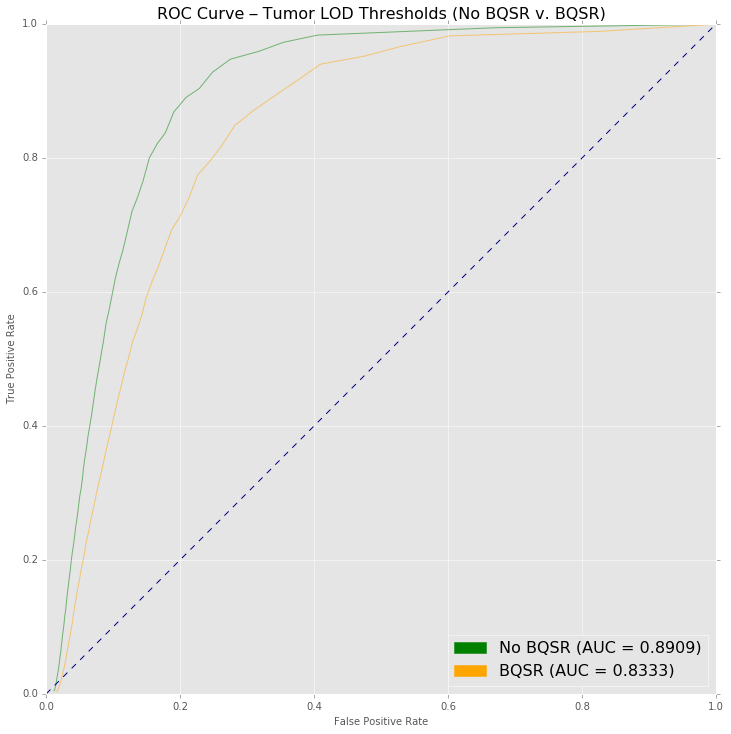

In [5]:
plotCurve([condition1Analysis, condition2Analysis], ["No BQSR", "BQSR"], xKey = "fpr", yKey = "tpr", xLabel = "False Positive Rate", yLabel = "True Positive Rate", title = "ROC Curve – Tumor LOD Thresholds (No BQSR v. BQSR)", diag = "bottom", method = "plot")

### Sensitivity Specificity Curve (No BQSR Condition v. BQSR Condition)

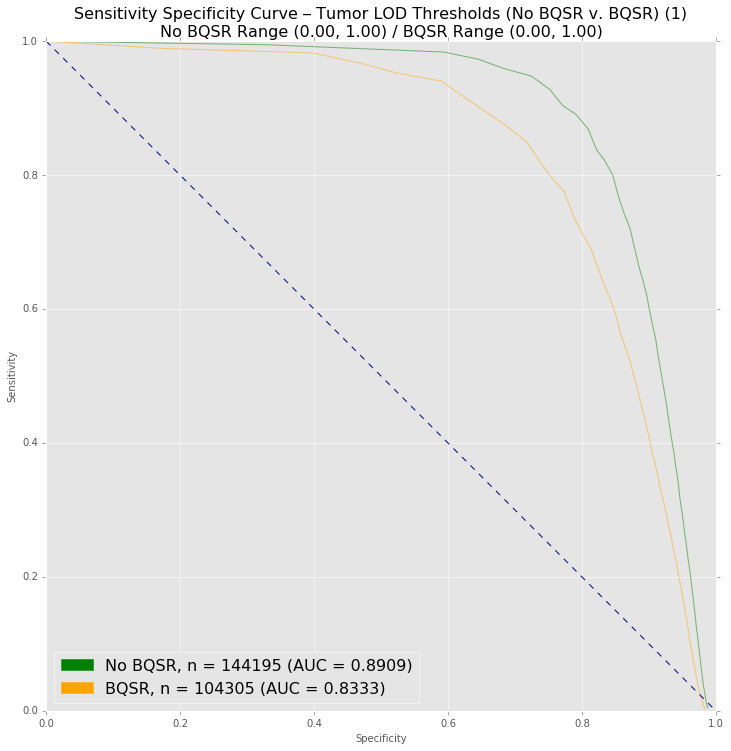

In [6]:
#
# Generate Sensitivity-Specificity Curve
#

# Individual Plots
plotCurves([(0.0, 1.0)], [(0.0, 1.0)], trSet, c1HashMap, c2HashMap, subsetKey = "AF", c1Label = "No BQSR", c2Label = "BQSR", titleStr = "Sensitivity Specificity Curve – Tumor LOD Thresholds (No BQSR v. BQSR)")

### Second Look: What Threshold Results in The Max Combined Sensitivity-Specificity?

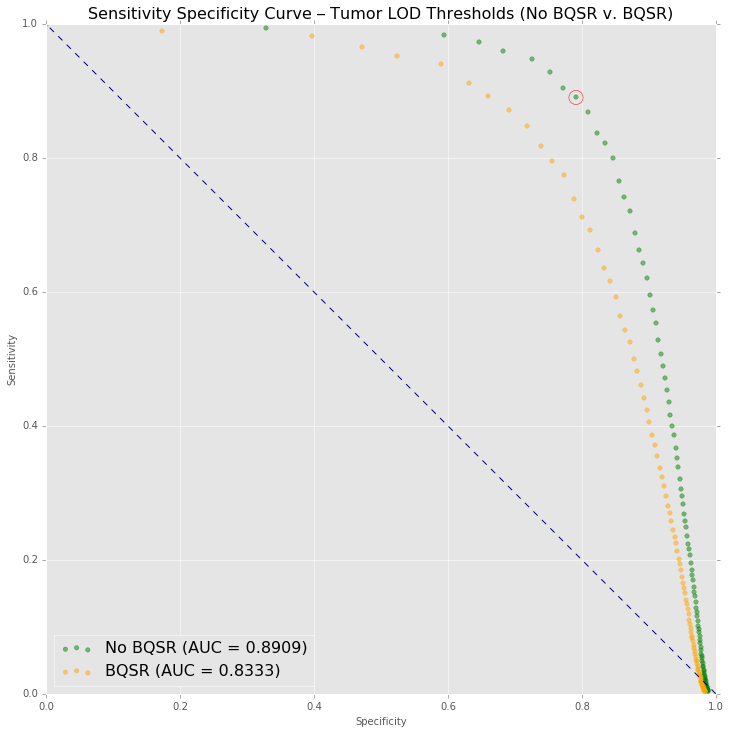

In [7]:
#
# Generate Sensitivity-Specificity Curve - With Maximum Combination
#

# Setup
fig         = Plot.figure(1, (12, 12), dpi = 1200)
axis        = fig.add_subplot(111)
axis.set_ylabel('Sensitivity', fontsize = 10)
axis.set_xlabel('Specificity', fontsize = 10)
# Scatter
c1, c1X, c1Y = scatterXY(condition1Analysis, "specificity", "sensitivity", "green")
c2, c2X, c2Y = scatterXY(condition2Analysis, "specificity", "sensitivity", "orange")
c1Auc = metrics.auc(c1X, c1Y)
c2Auc = metrics.auc(c2X, c2Y)
c1Label = "No BQSR (AUC = %.4f)" % c1Auc
c2Label = "BQSR (AUC = %.4f)" % c2Auc
# Annotate Maximized Threshold
m  = plotMaximized(condition1Analysis, "specificity", "sensitivity")
# Plot
Plot.plot([1, 0], [0, 1], color='navy', lw=1, linestyle='--')
Plot.ylim([0, 1])
Plot.xlim([0, 1])
Plot.title("Sensitivity Specificity Curve – Tumor LOD Thresholds (No BQSR v. BQSR)", fontsize = 16)
Plot.legend((c1, c2), (c1Label, c2Label), loc = 'lower left', fontsize = 16)
Plot.show()
    

## Optimal Threshold Analysis

### No BQSR Condition Statistics

In [8]:
printBest(condition1Analysis) # Accuracy
printBest(condition1Analysis, "f1score")
printBest(condition1Analysis, "ppv")

Best Threshold by 'accuracy'

Tumor LOD Threshold: 99

	True Positive:     65
	True Negative:     127494
	False Positive:    1492
	False Negative:    15144

	TPR:               0.43%
	TNR:               98.84%
	FPR:               1.16%
	FNR:               99.57%

	Sensitivity:       0.43%
	Specificity:       98.84%

	Precision:         4.17%
	Recall:            0.43%

	Accuracy:          88.46%
	F1-Score:          0.78%

	FDR:               95.83%
	FOR:               10.62%

	NPV:               89.38%
	PPV:               4.17%

	Diagnostic OR:     36.68

Best Threshold by 'f1score'

Tumor LOD Threshold: 16

	True Positive:     12173
	True Negative:     109113
	False Positive:    19873
	False Negative:    3036

	TPR:               80.04%
	TNR:               84.59%
	FPR:               15.41%
	FNR:               19.96%

	Sensitivity:       80.04%
	Specificity:       84.59%

	Precision:         37.99%
	Recall:            80.04%

	Accuracy:          84.11%
	F1-Score:          51.52%

	FDR: 

### BQSR Condition Statistics

In [9]:
printBest(condition2Analysis) # Accuracy
printBest(condition2Analysis, "f1score")
printBest(condition1Analysis, "ppv")

Best Threshold by 'accuracy'

Tumor LOD Threshold: 99

	True Positive:     51
	True Negative:     87723
	False Positive:    1390
	False Negative:    15141

	TPR:               0.34%
	TNR:               98.44%
	FPR:               1.56%
	FNR:               99.66%

	Sensitivity:       0.34%
	Specificity:       98.44%

	Precision:         3.54%
	Recall:            0.34%

	Accuracy:          84.15%
	F1-Score:          0.61%

	FDR:               96.46%
	FOR:               14.72%

	NPV:               85.28%
	PPV:               3.54%

	Diagnostic OR:     21.26

Best Threshold by 'f1score'

Tumor LOD Threshold: 16

	True Positive:     11778
	True Negative:     68929
	False Positive:    20184
	False Negative:    3414

	TPR:               77.53%
	TNR:               77.35%
	FPR:               22.65%
	FNR:               22.47%

	Sensitivity:       77.53%
	Specificity:       77.35%

	Precision:         36.85%
	Recall:            77.53%

	Accuracy:          77.38%
	F1-Score:          49.96%

	FDR:   

# BQSR / No BQSR Low VAF Performance Comparison - All Variants

In [10]:
# Get Metrics
c1AfVals = sorted(getFormatData(c1HashMap, key="AF")[0])
c2AfVals = sorted(getFormatData(c2HashMap, key="AF")[0])

#
# Low VAF
#

c1AfLowSplit = [x for x in c1AfVals if x > 0.0 and x <= 0.05]
c2AfLowSplit = [x for x in c2AfVals if x > 0.0 and x <= 0.05]
c1AfMedSplit = [x for x in c1AfVals if x > 0.05 and x <= 0.1]
c2AfMedSplit = [x for x in c2AfVals if x > 0.05 and x <= 0.1]
c1AfHighSplit = [x for x in c1AfVals if x > 0.1 and x <= 0.15]
c2AfHighSplit = [x for x in c2AfVals if x > 0.1 and x <= 0.15]

# Low Range Tuples
c1AfLowTups = (min(c1AfLowSplit), max(c1AfLowSplit))
c2AfLowTups = (min(c2AfLowSplit), max(c2AfLowSplit))
c1AfMedTups = (min(c1AfMedSplit), max(c1AfMedSplit))
c2AfMedTups = (min(c2AfMedSplit), max(c2AfMedSplit))
c1AfHighTups = (min(c1AfHighSplit), max(c1AfHighSplit))
c2AfHighTups = (min(c2AfHighSplit), max(c2AfHighSplit))

# Note: We could just hand the range tuples - but this bounds the tuple values by the actual data values present

## 0.0 - 0.05 VAF - All

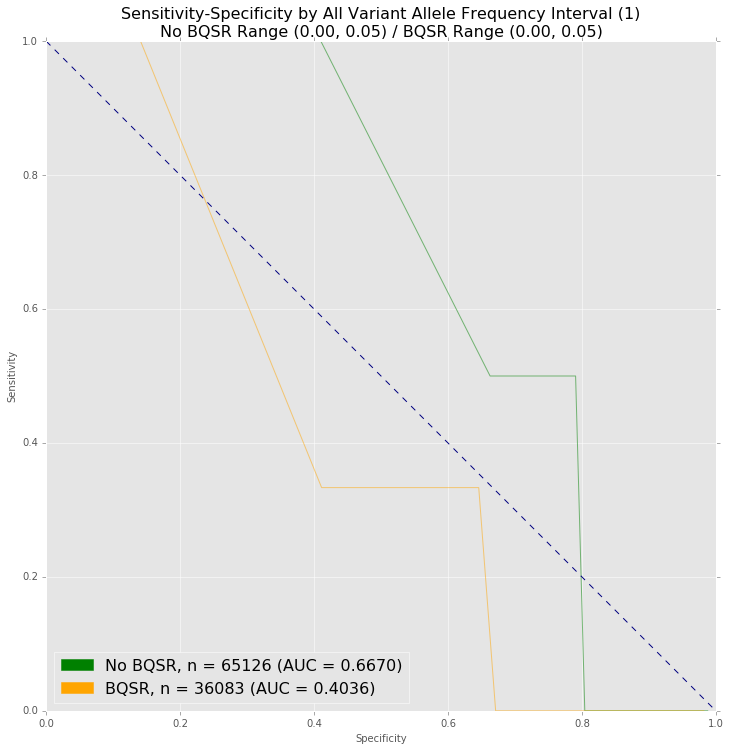

In [11]:
# Individual Plots
plotCurves([c1AfLowTups], [c2AfLowTups], trSet, c1HashMap, c2HashMap, subsetKey = "AF", c1Label = "No BQSR", c2Label = "BQSR", titleStr = "Sensitivity-Specificity by All Variant Allele Frequency Interval")

## 0.05 - 0.1 VAF - All

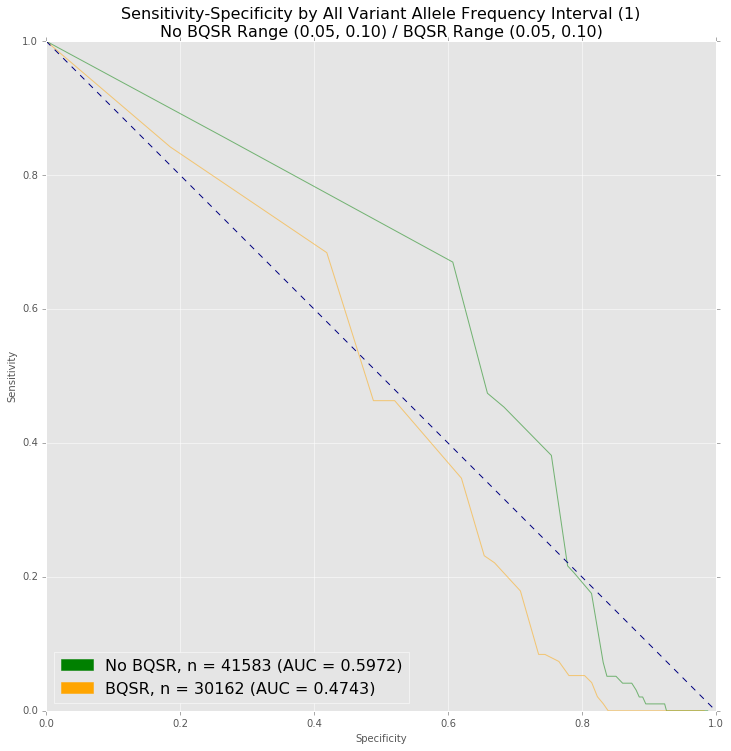

In [12]:
# Individual Plots
plotCurves([c1AfMedTups], [c2AfMedTups], trSet, c1HashMap, c2HashMap, subsetKey = "AF", c1Label = "No BQSR", c2Label = "BQSR", titleStr = "Sensitivity-Specificity by All Variant Allele Frequency Interval")

## 0.1 - 0.15 VAF - All

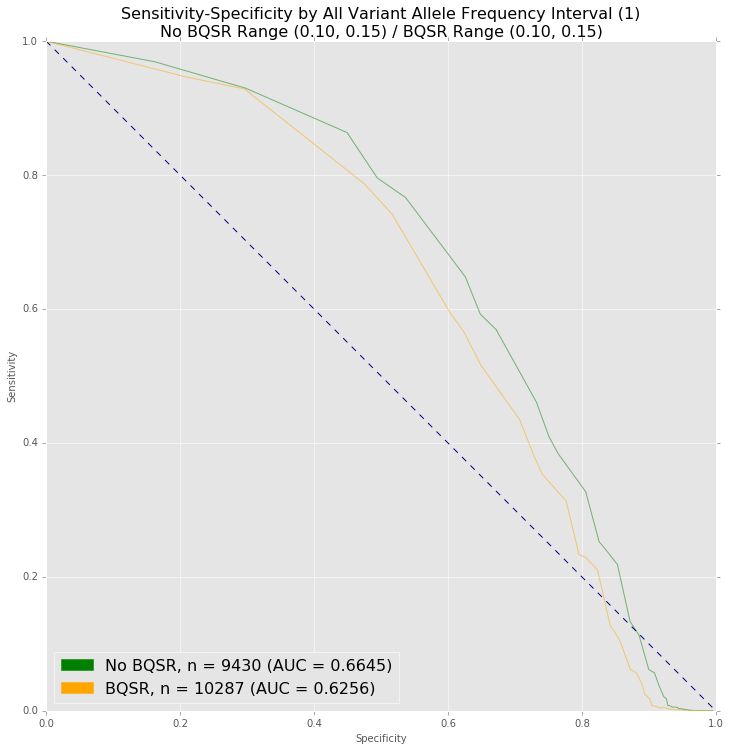

In [13]:
# Individual Plots
plotCurves([c1AfHighTups], [c2AfHighTups], trSet, c1HashMap, c2HashMap, subsetKey = "AF", c1Label = "No BQSR", c2Label = "BQSR", titleStr = "Sensitivity-Specificity by All Variant Allele Frequency Interval")

# BQSR / No BQSR Low VAF Performance Comparison - Passing Variants
### Is MuTect (Under Default Settings) Generating False Negatives?

In [14]:
# Get Metrics
c1AfVals, excl = getFormatData(c1Passing, key="AF")
c2AfVals, excl = getFormatData(c2Passing, key="AF")

c1AfVals = sorted(c1AfVals)
c2AfVals = sorted(c2AfVals)

#
# Low VAF
# 

c1AfLowSplit = [x for x in c1AfVals if x > 0.0 and x <= 0.05]
c2AfLowSplit = [x for x in c2AfVals if x > 0.0 and x <= 0.05]
c1AfMedSplit = [x for x in c1AfVals if x > 0.05 and x <= 0.1]
c2AfMedSplit = [x for x in c2AfVals if x > 0.05 and x <= 0.1]
c1AfHighSplit = [x for x in c1AfVals if x > 0.1 and x <= 0.15]
c2AfHighSplit = [x for x in c2AfVals if x > 0.1 and x <= 0.15]

# Low Range Tuples
c1AfLowTups = (min(c1AfLowSplit), max(c1AfLowSplit))
c2AfLowTups = (min(c2AfLowSplit), max(c2AfLowSplit))
c1AfMedTups = (min(c1AfMedSplit), max(c1AfMedSplit))
c2AfMedTups = (min(c2AfMedSplit), max(c2AfMedSplit))
c1AfHighTups = (min(c1AfHighSplit), max(c1AfHighSplit))
c2AfHighTups = (min(c2AfHighSplit), max(c2AfHighSplit))

## 0.0 - 0.05 VAF - Passing

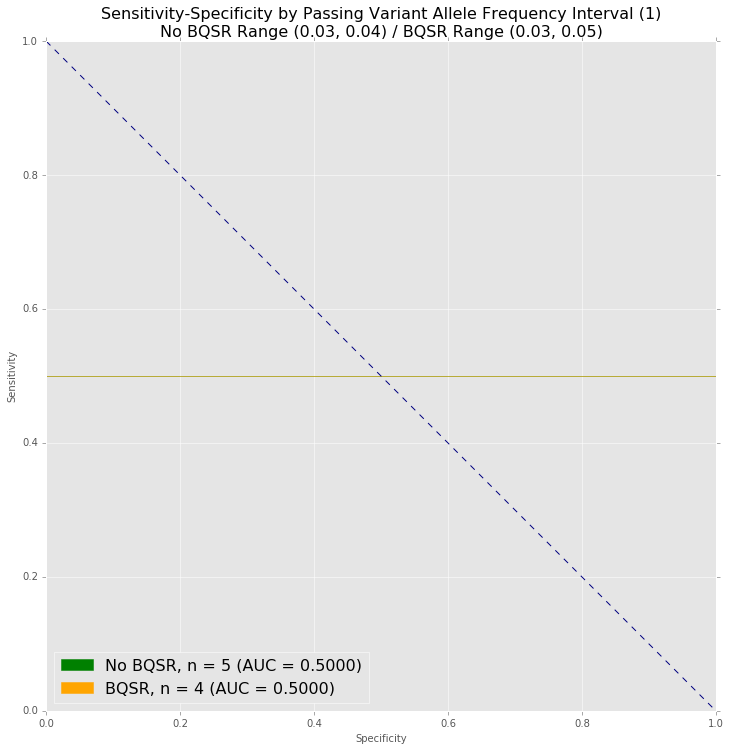

In [15]:
# Individual Plots
plotCurves([c1AfLowTups], [c2AfLowTups], trSet, c1Passing, c2Passing, subsetKey = "AF", c1Label = "No BQSR", c2Label = "BQSR", titleStr = "Sensitivity-Specificity by Passing Variant Allele Frequency Interval")

## 0.05 - 0.1 VAF - Passing

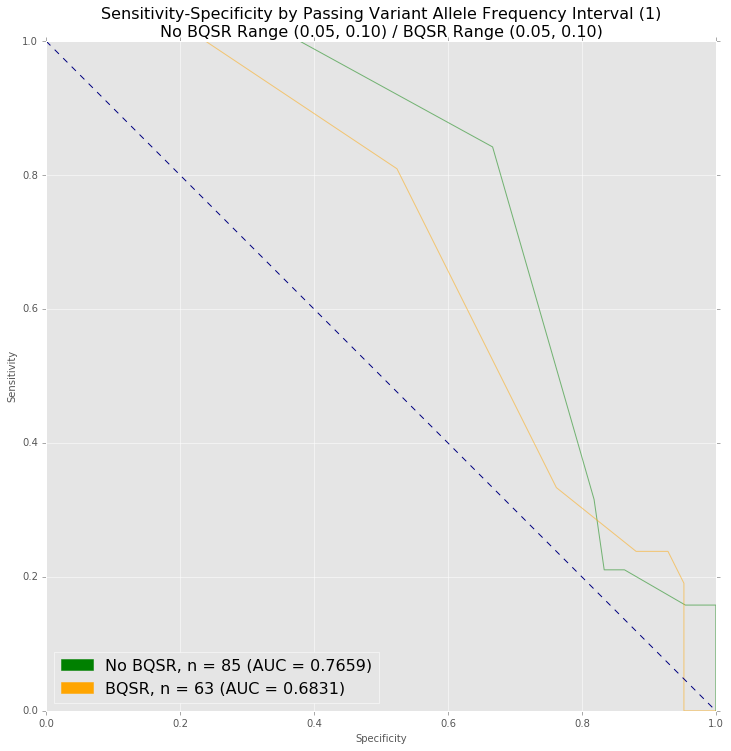

In [16]:
# Individual Plots
plotCurves([c1AfMedTups], [c2AfMedTups], trSet, c1Passing, c2Passing, subsetKey = "AF", c1Label = "No BQSR", c2Label = "BQSR", titleStr = "Sensitivity-Specificity by Passing Variant Allele Frequency Interval")

## 0.1 - 0.15 VAF - Passing

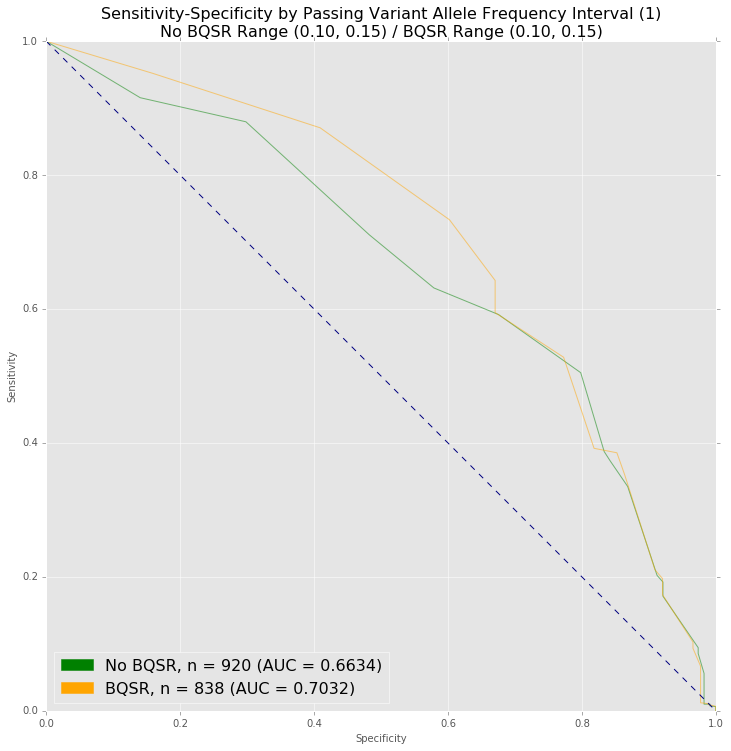

In [17]:
# Individual Plots
plotCurves([c1AfHighTups], [c2AfHighTups], trSet, c1Passing, c2Passing, subsetKey = "AF", c1Label = "No BQSR", c2Label = "BQSR", titleStr = "Sensitivity-Specificity by Passing Variant Allele Frequency Interval")

# Which Mutect2 Filters Are Creating False Negatives?

In [18]:
from collections import defaultdict

#
# Truth Set
#

# Subset HashMaps by VAF Range
trSub, excluded = subsetHashMapByInfoThreshold(trHashMap, 0.15, operation = "<=", key = "VAF")
# Truth Set 0.10 - 0.15
trSubGt10, trExcludedLt10 = subsetHashMapByInfoThreshold(trSub, 0.10, operation = "<=", key = "VAF")
# Truth Set 0.00 - 0.05; 0.05 - 0.10
trSubGt00, trSubGt05 = subsetHashMapByInfoThreshold(trExcludedLt10, 0.05, operation = "<=", key = "VAF")

#
# No BQSR - All
#

c1Sub, excluded = subsetHashMapByFormatThreshold(c1HashMap, 0.15, operation = "<=", key = "AF")
# All - No BQSR Set 0.10 - 0.15
c1SubGt10, c1ExcludedLt10 = subsetHashMapByFormatThreshold(c1Sub, 0.10, operation = "<=", key = "AF")
# All - No BQSR Set 0.00 - 0.05; 0.05 - 0.10
c1SubGt00, c1SubGt05 = subsetHashMapByFormatThreshold(c1ExcludedLt10, 0.05, operation = "<=", key = "AF")

#
# No BQSR - Passing
#

c1PassSub, excluded = subsetHashMapByFormatThreshold(c1Passing, 0.15, operation = "<=", key = "AF")
# Passing - No BQSR Set 0.10 - 0.15
c1PassSubGt10, c1PassExcludedLt10 = subsetHashMapByFormatThreshold(c1PassSub, 0.10, operation = "<=", key = "AF")
# Passing - No BQSR Set 0.00 - 0.05; 0.05 - 0.10
c1PassSubGt00, c1PassSubGt05 = subsetHashMapByFormatThreshold(c1PassExcludedLt10, 0.05, operation = "<=", key = "AF")

#
# BQSR - All
#

c2Sub, excluded = subsetHashMapByFormatThreshold(c2HashMap, 0.15, operation = "<=", key = "AF")
# All - BQSR Set 0.10 - 0.15
c2SubGt10, c2ExcludedLt10 = subsetHashMapByFormatThreshold(c2Sub, 0.10, operation = "<=", key = "AF")
# All - BQSR Set 0.00 - 0.05; 0.05 - 0.10
c2SubGt00, c2SubGt05 = subsetHashMapByFormatThreshold(c2ExcludedLt10, 0.05, operation = "<=", key = "AF")

#
# BQSR - Passing
#

c2PassSub, excluded = subsetHashMapByFormatThreshold(c2Passing, 0.15, operation = "<=", key = "AF")
# Passing - BQSR Set 0.10 - 0.15
c2PassSubGt10, c2PassExcludedLt10 = subsetHashMapByFormatThreshold(c2PassSub, 0.10, operation = "<=", key = "AF")
# Passing - BQSR Set 0.00 - 0.05; 0.05 - 0.10
c2PassSubGt00, c2PassSubGt05 = subsetHashMapByFormatThreshold(c2PassExcludedLt10, 0.05, operation = "<=", key = "AF")



## Plot Filter Frequencies for False Negatives - VAF [0.10 - 0.15]

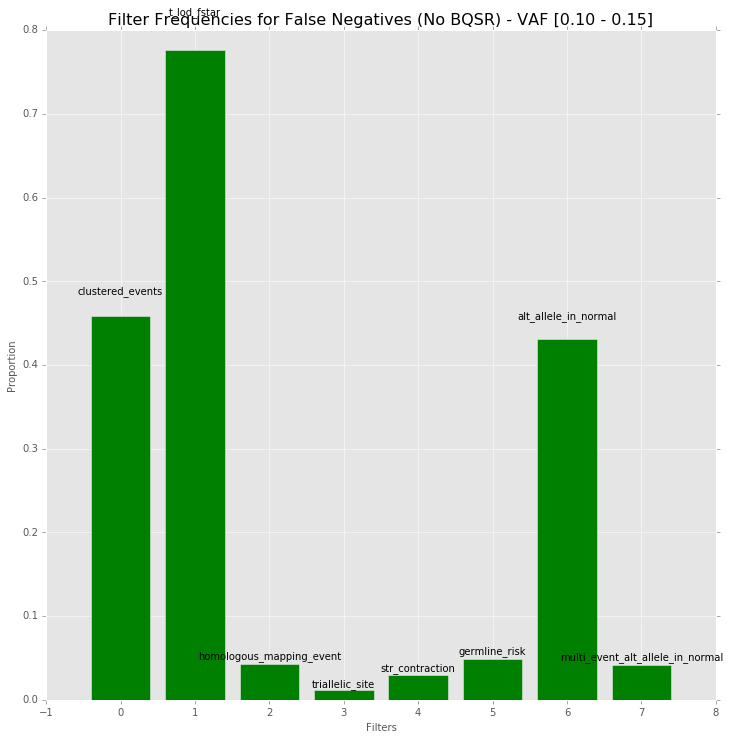

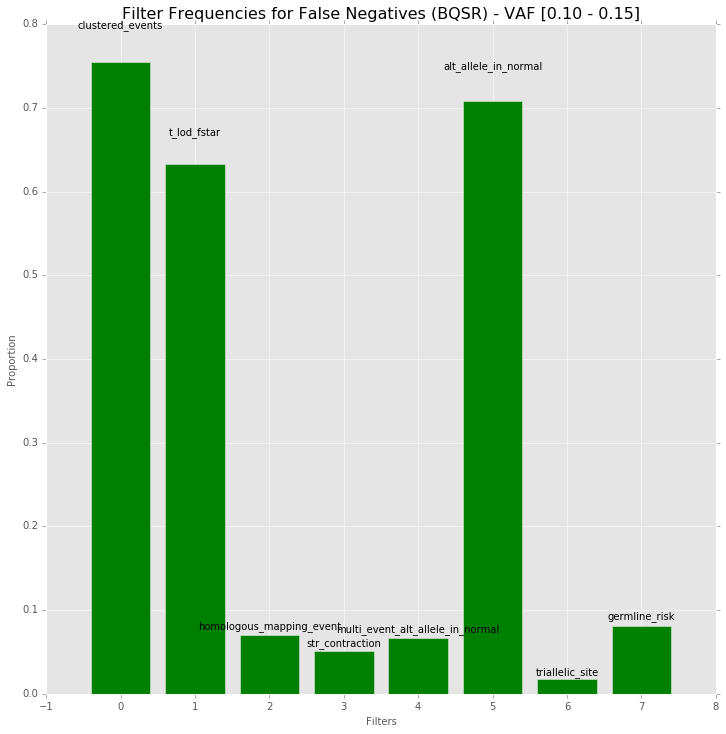

In [19]:
# Plot Filter Frequencies – False Negatives - No BQSR Set 0.10 - 0.15

# Get True Keys For False Negatives
diff = set(c1SubGt10.keys()) - set(c1PassSubGt10.keys())
c1SubGt10Fn = subsetHashMapByKeys(c1SubGt10, diff)
if len(c1SubGt10Fn) > 0:
    # Generate Filter Frequencies Plot
    plotFilterFrequencies(c1SubGt10Fn, title = "Filter Frequencies for False Negatives (No BQSR) - VAF [0.10 - 0.15]", xlabel = "Filters", ylabel = "Proportion")

# Plot Filter Frequencies – False Negatives - BQSR Set 0.10 - 0.15

# Get True Keys For False Negatives
diff = set(c2SubGt10.keys()) - set(c2PassSubGt10.keys())
c2SubGt10Fn = subsetHashMapByKeys(c2SubGt10, diff)
if len(c2SubGt10Fn) > 0:
    # Generate Filter Frequencies Plot
    plotFilterFrequencies(c2SubGt10Fn, title = "Filter Frequencies for False Negatives (BQSR) - VAF [0.10 - 0.15]", xlabel = "Filters", ylabel = "Proportion")

## Plot Filter Frequencies for False Negatives - VAF [0.05 - 0.10]

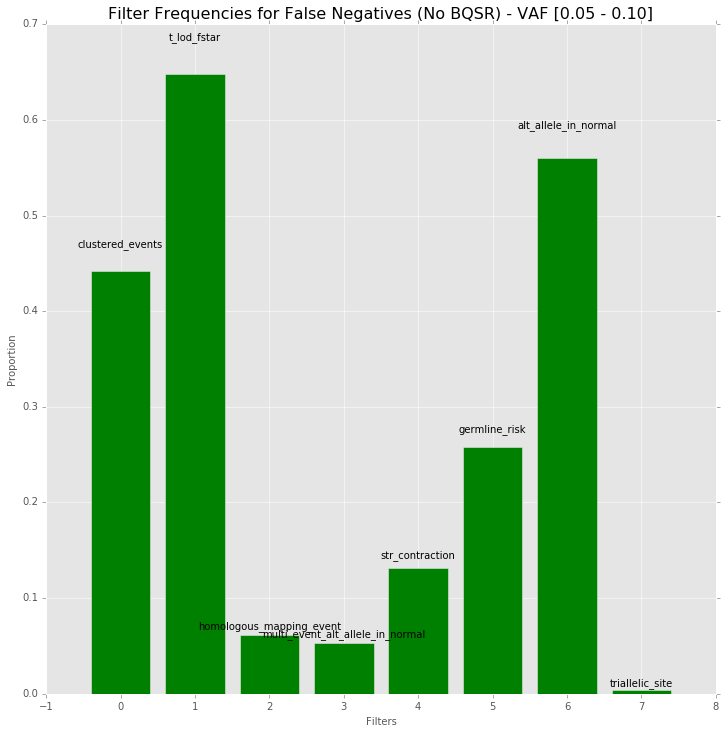

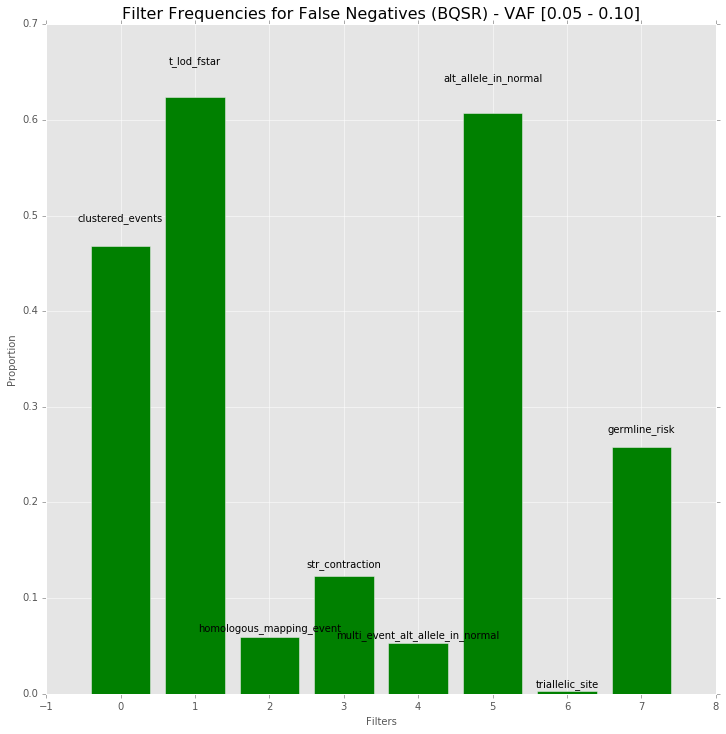

In [20]:
# Plot Filter Frequencies – False Negatives - No BQSR Set 0.05 - 0.10

# Get True Keys For False Negatives
diff = set(c1SubGt05.keys()) - set(c1PassSubGt05.keys())
c1SubGt05Fn = subsetHashMapByKeys(c1SubGt05, diff)
if len(c1SubGt05Fn) > 0:
    # Generate Filter Frequencies Plot
    plotFilterFrequencies(c1SubGt05Fn, title = "Filter Frequencies for False Negatives (No BQSR) - VAF [0.05 - 0.10]", xlabel = "Filters", ylabel = "Proportion")

# Plot Filter Frequencies – False Negatives - BQSR Set 0.05 - 0.10

# Get True Keys For False Negatives
diff = set(c2SubGt05.keys()) - set(c2PassSubGt05.keys())
c2SubGt05Fn = subsetHashMapByKeys(c2SubGt05, diff)
if len(c2SubGt05Fn) > 0:
    # Generate Filter Frequencies Plot
    plotFilterFrequencies(c2SubGt05Fn, title = "Filter Frequencies for False Negatives (BQSR) - VAF [0.05 - 0.10]", xlabel = "Filters", ylabel = "Proportion")

## Plot Filter Frequencies for False Negatives - VAF [< 0.01 - 0.05]

In [21]:
# Plot Filter Frequencies – False Negatives - No BQSR Set < 0.01 - 0.05

# Get True Keys For False Negatives
diff = set(c1SubGt00.keys()) - set(c1PassSubGt00.keys())
c1SubGt00Fn = subsetHashMapByKeys(c1SubGt00, diff)
if len(c1SubGt00Fn) > 0:
    # Generate Filter Frequencies Plot
    plotFilterFrequencies(c1SubGt00Fn)

# Plot Filter Frequencies – False Negatives - BQSR Set < 0.01 - 0.05

# Get True Keys For False Negatives
diff = set(c2SubGt00.keys()) - set(c2PassSubGt00.keys())
c2SubGt00Fn = subsetHashMapByKeys(c2SubGt00, diff)
if len(c2SubGt00Fn) > 0:
    # Generate Filter Frequencies Plot
    plotFilterFrequencies(c2SubGt00Fn)

# Mutect2 Performance at Low VAF
## Called / Not Called by MuTect2 by VAF Range [> 0.00 - 0.05]; [0.05 - 0.10]; [0.10 - 0.15]

In [22]:
#
# Map Analysis
#

trCombinations = [trSubGt10, trSubGt05, trSubGt00]
combinations = [
    [
        {"label": "No BQSR - All - [0.10 - 0.15] VAF", "data": c1SubGt10}, 
        {"label": "No BQSR - All - [0.05 - 0.10] VAF", "data": c1SubGt05},
        {"label": "No BQSR - All - [> 0.00 - 0.05] VAF", "data": c1SubGt00}
    ],
    [
        {"label": "BQSR - All - [0.10 - 0.15] VAF", "data": c2SubGt10}, 
        {"label": "BQSR - All - [0.05 - 0.10] VAF", "data": c2SubGt05}, 
        {"label": "BQSR - All - [> 0.00 - 0.05] VAF", "data": c2SubGt00}
    ],
    [
        {"label": "No BQSR - Passing - [0.10 - 0.15] VAF", "data": c1PassSubGt10}, 
        {"label": "No BQSR - Passing - [0.05 - 0.10] VAF", "data": c1PassSubGt05}, 
        {"label": "No BQSR - Passing - [> 0.00 - 0.05] VAF", "data": c1PassSubGt00}
    ],
    [
        {"label": "BQSR - Passing - [0.10 - 0.15] VAF", "data": c2PassSubGt10}, 
        {"label": "BQSR - Passing - [0.05 - 0.10] VAF", "data": c2PassSubGt05}, 
        {"label": "BQSR - Passing - [> 0.00 - 0.05] VAF", "data": c2PassSubGt00}
    ]
]

# Generate Analyses
analysisSets = []
for combination in combinations:
    for truth, condition in zip(trCombinations, combination):
        a = generateAnalysis(condition["data"], truth)
        analysisSets.append({"label": condition["label"], "analysis": a})

# Print Analyses
i = 0
for analysisSet in analysisSets:
    print("Mutect2 Performance: %s" % analysisSet["label"])
    print("\tCalled by MuTect2 (TPR): %.4f%%" % analysisSet["analysis"]["tpr"])
    print("\tMissed by MuTect2 (FNR): %.4f%%" % analysisSet["analysis"]["fnr"])
    print("\tTNR:                     %.4f%%" % analysisSet["analysis"]["tnr"])
    print("\tFPR:                     %.4f%%" % analysisSet["analysis"]["fpr"])
    print("\tSensitivity:             %.4f%%" % analysisSet["analysis"]["sensitivity"])
    print("\tSpecificity:             %.4f%%" % analysisSet["analysis"]["specificity"])
    print("\tAccuracy:                %.4f%%" % analysisSet["analysis"]["accuracy"])
    print("n = %d" % analysisSet["analysis"]["n"])
    brk()
    i += 1
    if (i % 3 == 0):
        print("==================================================")

Mutect2 Performance: No BQSR - All - [0.10 - 0.15] VAF
	Called by MuTect2 (TPR): 0.5000%
	Missed by MuTect2 (FNR): 0.5000%
	TNR:                     0.9882%
	FPR:                     0.0118%
	Sensitivity:             0.5000%
	Specificity:             0.9882%
	Accuracy:                0.9882%
n = 109223

--------------------------------------------------

Mutect2 Performance: No BQSR - All - [0.05 - 0.10] VAF
	Called by MuTect2 (TPR): 0.0000%
	Missed by MuTect2 (FNR): 1.0000%
	TNR:                     0.9963%
	FPR:                     0.0037%
	Sensitivity:             0.0000%
	Specificity:             0.9963%
	Accuracy:                0.9939%
n = 9504

--------------------------------------------------

Mutect2 Performance: No BQSR - All - [> 0.00 - 0.05] VAF
	Called by MuTect2 (TPR): 0.5000%
	Missed by MuTect2 (FNR): 0.5000%
	TNR:                     0.5000%
	FPR:                     0.5000%
	Sensitivity:             0.5000%
	Specificity:             0.5000%
	Accuracy:                0